### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [2]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [3]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [4]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Sub_Category'])


In [5]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)


In [6]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [7]:
data.Sub_Category.value_counts()

Availability                         11626
Enterprise software                  11429
Job Failure                           7399
Poor performance                      4480
Data Issue                            4105
Website                               3425
Desktop Software                      2203
Information                           1824
Application availability              1576
Walk Through Solution                 1486
Redirect user                         1184
Error Message                         1135
Mobile                                 695
Login issue                            684
Performance                            611
End-User                               390
Remote Connectivity                    216
Password Reset                         167
Operating System                       159
MS SQL                                 149
Oracle                                 102
Windows                                 96
IT                                      94
Email      

In [8]:
data = data.groupby('Sub_Category').filter(lambda x : len(x)>1000)

In [9]:
data.Sub_Category.value_counts()

Availability                11626
Enterprise software         11429
Job Failure                  7399
Poor performance             4480
Data Issue                   4105
Website                      3425
Desktop Software             2203
Information                  1824
Application availability     1576
Walk Through Solution        1486
Redirect user                1184
Error Message                1135
Name: Sub_Category, dtype: int64

In [10]:
data.shape

(51872, 32)

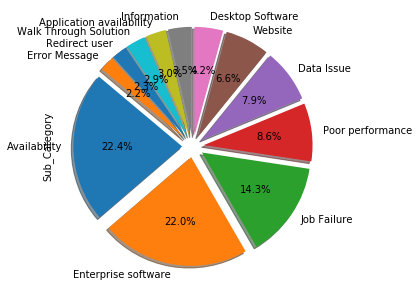

In [11]:
chart=data.Sub_Category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Sub_Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


from sklearn.utils import resample

df_1 = data[data.Sub_Category=='Availability']
df_2 = data[data.Sub_Category=='Enterprise software']
df_3 = data[data.Sub_Category=='Job Failure']
df_4 = data[data.Sub_Category=='Poor performance']
df_5 = data[data.Sub_Category=='Data Issue']
df_6 = data[data.Sub_Category=='Website']
df_7 = data[data.Sub_Category=='Desktop Software']
 
df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled])

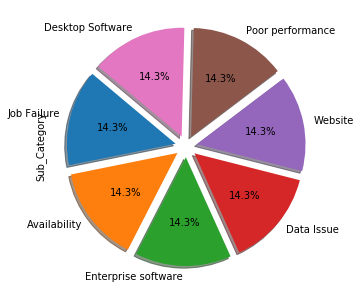

In [41]:
chart=data.Sub_Category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Sub_Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [12]:
data['target_sub'] = data.Sub_Category.astype('category').cat.codes


In [13]:
labels_sub = data.Sub_Category.astype('category').cat.categories


In [14]:
df = pd.DataFrame(labels_sub)
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_sub.csv') 


In [15]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sub
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,11
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,7
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,8
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04,11
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,3


In [16]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [17]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,20,50,100, np.inf], labels=['0-10', '10-20', '20-50','50-100' ,'>100'])


In [18]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [19]:
word_distribution.head()

,bins,counts
0,0-10,11826
1,10-20,19765
2,20-50,11267
3,50-100,6918
4,>100,2096


Text(0.5, 1.0, 'Word distribution per bin')

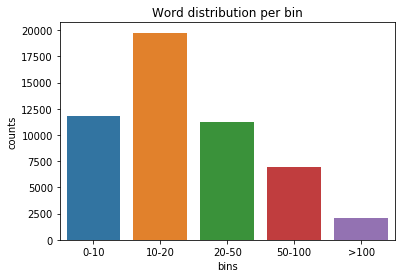

In [20]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [21]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sub,num_words,bins
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,11,10,0-10
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,7,8,0-10
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,8,20,10-20
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04,11,1,0-10
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,3,5,0-10


In [21]:
num_class_sub = len(np.unique(data.Sub_Category.values))
y_sub = data['target_sub'].values


## Topic Modelling

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [23]:
data['Description'] = data['Description'].astype(str)

In [24]:
type(data['Description'])

pandas.core.series.Series

In [25]:
data_description = data.Description.values

In [26]:
type(data_description)

numpy.ndarray

In [27]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

0000000 11.163406522012954
000000000 11.163406522012954
000000000000019445 11.163406522012954
000000000000080001 11.163406522012954
000000000000080002 11.163406522012954
000000000000080003 11.163406522012954
000000000000080004 11.163406522012954
000000000000080005 11.163406522012954
000000000000080006 11.163406522012954
000000000000080007 11.163406522012954
000000000000080008 11.163406522012954
000000000000080009 11.163406522012954
000000000000080010 11.163406522012954
000000000000080011 11.163406522012954
000000000000080015 11.163406522012954
000000000000080018 11.163406522012954
000000000000080019 11.163406522012954
000000000000080020 11.163406522012954
000000000000080021 11.163406522012954
000000000000080022 11.163406522012954
000000000000080023 11.163406522012954
000000000000080024 11.163406522012954
000000000000080025 11.163406522012954
000000000000080026 11.163406522012954
000000000000080027 11.163406522012954
000000000000080028 11.163406522012954
000000000000080029 11.1634065220

095 11.163406522012954
0950000001 11.163406522012954
0956027777 11.163406522012954
0956939050 11.163406522012954
0963307247 11.163406522012954
0966005075 11.163406522012954
0966591835 11.163406522012954
097 11.163406522012954
0970996091 11.163406522012954
0972072933 11.163406522012954
0972604418 11.163406522012954
0979385259 11.163406522012954
098 11.163406522012954
0982844026 11.163406522012954
098296 11.163406522012954
0983 11.163406522012954
0983124513 11.163406522012954
0985223515 11.163406522012954
0987147891 11.163406522012954
0989464588 11.163406522012954
09b038c6e3e9c812015d2697a52c83bd0015da779f622 11.163406522012954
09dq2 11.163406522012954
09sgt 11.163406522012954
0_131 11.163406522012954
0_60 11.163406522012954
0_72 11.163406522012954
0_74 11.163406522012954
0a5e861g45f 11.163406522012954
0a94048f89cd 11.163406522012954
0b61b7e7032f 11.163406522012954
0b746d63fc6f 11.163406522012954
0bc88589 11.163406522012954
0bd6f5c2ff8120000b81bce6197efe69 11.163406522012954
0btb 11.1634

15_04 11.163406522012954
15_15_adjitem 11.163406522012954
15hf3 11.163406522012954
15jan 11.163406522012954
15mahesh 11.163406522012954
15min 11.163406522012954
15pm 11.163406522012954
15v0a3bxtzw8m 11.163406522012954
15while 11.163406522012954
1600mcg 11.163406522012954
160193 11.163406522012954
16022 11.163406522012954
16051706 11.163406522012954
16055480 11.163406522012954
16059283 11.163406522012954
16061570 11.163406522012954
1606473 11.163406522012954
16072840 11.163406522012954
1608 11.163406522012954
16083350 11.163406522012954
160930 11.163406522012954
16098 11.163406522012954
160k 11.163406522012954
160x160 11.163406522012954
1610 11.163406522012954
1610001 11.163406522012954
1611 11.163406522012954
161128161040550 11.163406522012954
16119220 11.163406522012954
161298 11.163406522012954
16131027 11.163406522012954
161451 11.163406522012954
161459 11.163406522012954
16155698 11.163406522012954
16156659 11.163406522012954
16166248 11.163406522012954
1617994 11.163406522012954
1

2392k 11.163406522012954
2393 11.163406522012954
2395901 11.163406522012954
2396201 11.163406522012954
2396301 11.163406522012954
2396401 11.163406522012954
2396501 11.163406522012954
2396701 11.163406522012954
2396801 11.163406522012954
2396901 11.163406522012954
23996641 11.163406522012954
239m 11.163406522012954
23_118_f_sls_sgot 11.163406522012954
23k 11.163406522012954
23m 11.163406522012954
23nina 11.163406522012954
23pm 11.163406522012954
24011 11.163406522012954
24014 11.163406522012954
24028 11.163406522012954
240300 11.163406522012954
24053 11.163406522012954
24097 11.163406522012954
240a 11.163406522012954
240k 11.163406522012954
240mg 11.163406522012954
2410 11.163406522012954
24101930 11.163406522012954
24111 11.163406522012954
2415 11.163406522012954
2417 11.163406522012954
24173 11.163406522012954
2418 11.163406522012954
2420 11.163406522012954
24227 11.163406522012954
24269 11.163406522012954
24270 11.163406522012954
2429 11.163406522012954
2434 11.163406522012954
2435 

3i3508 11.163406522012954
3i3511 11.163406522012954
3i3513 11.163406522012954
3i3514 11.163406522012954
3i3879 11.163406522012954
3i3958 11.163406522012954
3i4121 11.163406522012954
3i4140 11.163406522012954
3i4853 11.163406522012954
3i4880 11.163406522012954
3i4882 11.163406522012954
3i4939 11.163406522012954
3i4943 11.163406522012954
3i4945 11.163406522012954
3i4948 11.163406522012954
3i4957 11.163406522012954
3i4959 11.163406522012954
3i4965 11.163406522012954
3i4967 11.163406522012954
3i4972 11.163406522012954
3i4975 11.163406522012954
3i4976 11.163406522012954
3i4978 11.163406522012954
3i5138 11.163406522012954
3i5377 11.163406522012954
3i5437 11.163406522012954
3i5546 11.163406522012954
3i5573 11.163406522012954
3i5641 11.163406522012954
3i5815 11.163406522012954
3i5832 11.163406522012954
3i6055 11.163406522012954
3i6216 11.163406522012954
3i6217 11.163406522012954
3i6248 11.163406522012954
3i6365 11.163406522012954
3i6397 11.163406522012954
3i6398 11.163406522012954
3i6612 11.16

4582942 11.163406522012954
458314 11.163406522012954
4583344 11.163406522012954
4583586 11.163406522012954
4583589 11.163406522012954
4583592 11.163406522012954
4583913 11.163406522012954
4583977 11.163406522012954
4583999 11.163406522012954
4584247 11.163406522012954
4584298 11.163406522012954
4584465 11.163406522012954
4584564 11.163406522012954
4585625 11.163406522012954
4585647 11.163406522012954
4585651 11.163406522012954
45861429 11.163406522012954
4586497 11.163406522012954
4587186 11.163406522012954
4587382 11.163406522012954
4587401 11.163406522012954
4587506 11.163406522012954
4587523 11.163406522012954
4587524 11.163406522012954
4587530 11.163406522012954
4587728 11.163406522012954
4588 11.163406522012954
4588130 11.163406522012954
4588151 11.163406522012954
4588157 11.163406522012954
4588416 11.163406522012954
4589923 11.163406522012954
4589982 11.163406522012954
4590632 11.163406522012954
4590662 11.163406522012954
4590929 11.163406522012954
4590935 11.163406522012954
4591

5089191 11.163406522012954
5089192 11.163406522012954
5089193 11.163406522012954
5089594 11.163406522012954
5089700 11.163406522012954
5090571 11.163406522012954
509061784fa61f849a8ac3a01210c78a 11.163406522012954
5091410 11.163406522012954
5092047 11.163406522012954
50922 11.163406522012954
50923 11.163406522012954
5092672 11.163406522012954
5092674 11.163406522012954
5092738 11.163406522012954
5093024 11.163406522012954
5093684 11.163406522012954
5097 11.163406522012954
5097731 11.163406522012954
5097733 11.163406522012954
50g 11.163406522012954
50maria 11.163406522012954
50mg 11.163406522012954
50min 11.163406522012954
50paula 11.163406522012954
50u9jgrvww 11.163406522012954
5102632 11.163406522012954
5104 11.163406522012954
5105181 11.163406522012954
5105240 11.163406522012954
5106828 11.163406522012954
5106912 11.163406522012954
5106942 11.163406522012954
51099 11.163406522012954
51100003 11.163406522012954
51100006 11.163406522012954
51100011 11.163406522012954
51100014 11.163406

7426 11.163406522012954
743 11.163406522012954
7433038047 11.163406522012954
7433038048 11.163406522012954
7433038049 11.163406522012954
7433038056 11.163406522012954
7433456003 11.163406522012954
7436633002 11.163406522012954
7437488030 11.163406522012954
7437488036 11.163406522012954
7437503008 11.163406522012954
7437503033 11.163406522012954
74394 11.163406522012954
744001 11.163406522012954
74409_04 11.163406522012954
7441396028 11.163406522012954
7441396044 11.163406522012954
7441397009 11.163406522012954
7445905026 11.163406522012954
7445905032 11.163406522012954
744621396cbn 11.163406522012954
7448985033 11.163406522012954
7448985054 11.163406522012954
7449496001 11.163406522012954
7449496006 11.163406522012954
7449523008 11.163406522012954
7449523052 11.163406522012954
7454583029 11.163406522012954
7454583036 11.163406522012954
7460user 11.163406522012954
74625 11.163406522012954
7466 11.163406522012954
7466569033 11.163406522012954
7466569034 11.163406522012954
7469060003 11.1

ahr0chm6ly9wcm9kyml0ywjjb24uam5qlmnvbs90l0nvbnn1bwvyl3zpzxdzl1dxugfub3jhbwetu2hhcmvwawv3l05hdmlnyxrpb25qywdl 11.163406522012954
ahr0chm6ly9wcm9kymlzz2fwdgfilmpuai5jb20vdc9dt05bueroqs92awv3cy9pzmz0ywtls29yzwevrgfpbhlpzmz0ywtlpzplbwjlzd15jmftcds6c2hvd0fwcejhbm5lcj1mywxzzszhbxa7omrpc3bsyxlfy291bnq9bm8myw1wozpzag93vml6sg9tzt1ubw 11.163406522012954
ahr0chm6ly9wcm9kymlzz2fwdgfilmpuai5jb20viy9zaxrll0nptkfqre5bl3zpzxdzl1npbmdhcg9yzvnlbgwtaw5bbmfsexrpy3neyxnoym9hcmqvt3zlcnzpzxc 11.163406522012954
ai_0_90 11.163406522012954
aids 11.163406522012954
aikeda3 11.163406522012954
aiko 11.163406522012954
aimee 11.163406522012954
aiming 11.163406522012954
ainnerjoin 11.163406522012954
aippian 11.163406522012954
airawtch 11.163406522012954
airfare 11.163406522012954
airwatch_current 11.163406522012954
aisha 11.163406522012954
aizasybccpoit1ot5 11.163406522012954
aizasycvfvlnwoctkcq5eyxnwr1ck_tj05voydq 11.163406522012954
ajcollins 11.163406522012954
ajoshi41 11.163406522012954
ajuarezv 11.163406522012954


bk00gwf5mjiv5kfpduqbdszhmni3l4foqifysjtmwj8 11.163406522012954
bkilcoyn 11.163406522012954
bkim14 11.163406522012954
blackberry 11.163406522012954
blacklist 11.163406522012954
blade 11.163406522012954
blaise 11.163406522012954
blake 11.163406522012954
blakely 11.163406522012954
blambot 11.163406522012954
blanc 11.163406522012954
blanca 11.163406522012954
blanchard 11.163406522012954
blanco 11.163406522012954
blary 11.163406522012954
bldg 11.163406522012954
bleach 11.163406522012954
bleckenwegner 11.163406522012954
bleek 11.163406522012954
bleiben 11.163406522012954
blewis22 11.163406522012954
blijven 11.163406522012954
blill 11.163406522012954
blind 11.163406522012954
blink 11.163406522012954
blinking 11.163406522012954
bliss 11.163406522012954
blizard 11.163406522012954
blkr_16002 11.163406522012954
blob 11.163406522012954
bloccati 11.163406522012954
block__title 11.163406522012954
blockmanager 11.163406522012954
blockmanagerinfo 11.163406522012954
blockout 11.163406522012954
blokkere

creationg 11.163406522012954
creats 11.163406522012954
creazione 11.163406522012954
credit_cause_erp_key 11.163406522012954
credit_hold_day 11.163406522012954
credit_hold_release_day 11.163406522012954
credit_reason_erp_key 11.163406522012954
credited 11.163406522012954
credo_gr 11.163406522012954
creds 11.163406522012954
cree 11.163406522012954
creenshot 11.163406522012954
cremosa 11.163406522012954
cremoso 11.163406522012954
crescimento 11.163406522012954
crespo 11.163406522012954
cretae 11.163406522012954
cretain 11.163406522012954
creter 11.163406522012954
cretical 11.163406522012954
crfc 11.163406522012954
crhome 11.163406522012954
criado 11.163406522012954
criando 11.163406522012954
cricial 11.163406522012954
cris 11.163406522012954
criscone 11.163406522012954
cristiano 11.163406522012954
cristobal 11.163406522012954
criteo 11.163406522012954
critica 11.163406522012954
criticality_name 11.163406522012954
critically 11.163406522012954
critico 11.163406522012954
crm155248 11.163406

eccweb 11.163406522012954
ecdhe 11.163406522012954
ecfe1b92 11.163406522012954
ecg_co_cd 11.163406522012954
ecg_schema 11.163406522012954
ecgqa 11.163406522012954
echec 11.163406522012954
echelpoel 11.163406522012954
echeverri 11.163406522012954
echo 11.163406522012954
eckelmann 11.163406522012954
ecmms 11.163406522012954
eco 11.163406522012954
ecommunity 11.163406522012954
economiques 11.163406522012954
econtext 11.163406522012954
ecoperationdashboard 11.163406522012954
ect 11.163406522012954
ecunha 11.163406522012954
ecvv120ccp 11.163406522012954
ed2c 11.163406522012954
ed45dd49 11.163406522012954
ed7e8b5bdb02a3c0ff88158239961911 11.163406522012954
ed88a41d2609 11.163406522012954
edalva 11.163406522012954
edc 11.163406522012954
eddit 11.163406522012954
edg_gmed_support_l2 11.163406522012954
edgeprd 11.163406522012954
edgtransaction 11.163406522012954
edi1210143643hk5120190307_00001 11.163406522012954
edi221012766920190223_00001 11.163406522012954
edi2210128097hk5220190228_00001 11.16

fvl 11.163406522012954
fwe 11.163406522012954
fwk_icon_account_plan_vod__c_0 11.163406522012954
fwk_icon_address_vod__c_0 11.163406522012954
fwkatakana_hwkatakana 11.163406522012954
fxexp 11.163406522012954
fy2017 11.163406522012954
fylypiv 11.163406522012954
fzhang60 11.163406522012954
få 11.163406522012954
fått 11.163406522012954
g1 11.163406522012954
g100000007 11.163406522012954
g122h 11.163406522012954
g200000001 11.163406522012954
g4c 11.163406522012954
g6jxf 11.163406522012954
ga_master_job 11.163406522012954
gaal 11.163406522012954
gaapnetincafterafftransat 11.163406522012954
gabayet 11.163406522012954
gabbatua 11.163406522012954
gables 11.163406522012954
gabon 11.163406522012954
gabriela 11.163406522012954
gabrielsson 11.163406522012954
gabuniya 11.163406522012954
gadreau 11.163406522012954
gads 11.163406522012954
gaikwad 11.163406522012954
gained 11.163406522012954
gal 11.163406522012954
galaxy_bw 11.163406522012954
galaxy_copa 11.163406522012954
gale 11.163406522012954
galea

imapala 11.163406522012954
imat 11.163406522012954
imaware 11.163406522012954
imbalance 11.163406522012954
imbruvica4cll 11.163406522012954
imbuvica 11.163406522012954
imdb 11.163406522012954
imds 11.163406522012954
imedcal 11.163406522012954
imedical_insights 11.163406522012954
img0201 11.163406522012954
img0204 11.163406522012954
img2 11.163406522012954
img_compress 11.163406522012954
imges 11.163406522012954
imho 11.163406522012954
imitative 11.163406522012954
imiyazaw 11.163406522012954
imk 11.163406522012954
iml 11.163406522012954
imm_sg 11.163406522012954
imme 11.163406522012954
immideatly 11.163406522012954
immune 11.163406522012954
immunolgoy 11.163406522012954
immunology_rheumatology_spa 11.163406522012954
immunosuppressant 11.163406522012954
immutable 11.163406522012954
immédiatement 11.163406522012954
imo 11.163406522012954
imodiumus 11.163406522012954
imogas 11.163406522012954
impaa 11.163406522012954
impacst 11.163406522012954
impactados 11.163406522012954
impactando 11.16

jnj_contract_line_item 11.163406522012954
jnj_date 11.163406522012954
jnj_date_month 11.163406522012954
jnj_date_year 11.163406522012954
jnj_dtc_transdata_rog_yyyymmddhh24mmss 11.163406522012954
jnj_dtc_transdata_yyyymmddhh24mmss 11.163406522012954
jnj_groups 11.163406522012954
jnj_hcpconsumer_us_a_inventiv_yyyymmddhh24mmss 11.163406522012954
jnj_hcptargetlist_us_a_inventiv_yyyymmddhh24mmss 11.163406522012954
jnj_id 11.163406522012954
jnj_indep_sinergias_outros 11.163406522012954
jnj_indep_sinergias_top 11.163406522012954
jnj_inventiv_hcp_a_transdata_yyyymmddhh24mmss 11.163406522012954
jnj_month 11.163406522012954
jnj_month_name 11.163406522012954
jnj_organizational_units 11.163406522012954
jnj_pharma_comm_emea_dev 11.163406522012954
jnj_printers 11.163406522012954
jnj_prtn_cmpy 11.163406522012954
jnj_subcat_dyn 11.163406522012954
jnj_tyl_web_form_de 11.163406522012954
jnj_vision 11.163406522012954
jnj_year 11.163406522012954
jnjapacb15d3 11.163406522012954
jnjapacb15d6 11.163406522012

m_ro_outputlocale 11.163406522012954
m_ro_prompt 11.163406522012954
m_rpt_scg_sales_semantic_fw1 11.163406522012954
m_rpt_scg_sales_semantic_fw3 11.163406522012954
m_rpt_scg_sales_semantic_fw4 11.163406522012954
m_sdl_csl_retailerhierarchydefinition 11.163406522012954
m_sdl_csl_retailerhierarchydefinition_0_1 11.163406522012954
m_sdl_sap_bw_0account 11.163406522012954
m_sdl_sap_bw_0account_0_1 11.163406522012954
m_sdl_sap_bw_zc_sd 11.163406522012954
m_sdl_sap_bw_zc_sd_0_1 11.163406522012954
m_selloutdataload1 11.163406522012954
m_selloutdataload2 11.163406522012954
m_slt_batch_start 11.163406522012954
m_smd_int_rna_hier 11.163406522012954
m_spn_int_lfnt_prod_prfl_incr 11.163406522012954
m_store 11.163406522012954
m_t_acr_pricing_stg_txt 11.163406522012954
m_t_acr_pricing_stg_txt_0_1 11.163406522012954
m_territory_common 11.163406522012954
m_territory_hierarchy_it 11.163406522012954
m_trigger_ethicon_sales 11.163406522012954
m_united_item 11.163406522012954
m_user_territory 11.163406522

offs 11.163406522012954
offsetting 11.163406522012954
offshelfdisplaydetails 11.163406522012954
oging 11.163406522012954
ogon 11.163406522012954
ogp 11.163406522012954
ohara 11.163406522012954
ohashi 11.163406522012954
ohio 11.163406522012954
ohp1lo_i01t 11.163406522012954
ohp1lo_i03a 11.163406522012954
ohp1lo_i06a 11.163406522012954
ohp1lo_i10a 11.163406522012954
ohp1lo_i21a 11.163406522012954
ohp1mm_d13d 11.163406522012954
ohp1pm_d01d 11.163406522012954
ohp1sd_i47a 11.163406522012954
ohp1sd_i52a 11.163406522012954
ohs 11.163406522012954
ohsoolovely 11.163406522012954
ointment 11.163406522012954
oj 11.163406522012954
ojamäki 11.163406522012954
ojj_channel 11.163406522012954
ojos 11.163406522012954
okazaki 11.163406522012954
oklahoma 11.163406522012954
okmh2dcwiaeegyawztwdggubwbnabu5xy1z8gbxip54tpif1zmuleqdvyxyafjd7x8lutgqagsar6gajxd3t28 11.163406522012954
ola 11.163406522012954
olcsvay 11.163406522012954
oldpre 11.163406522012954
ole2 11.163406522012954
ole2notofficexmlfileexception 1

prty_rowid 11.163406522012954
pruddick 11.163406522012954
prueba 11.163406522012954
prz 11.163406522012954
przychodnia 11.163406522012954
przychodz 11.163406522012954
práticas 11.163406522012954
pré 11.163406522012954
prénom 11.163406522012954
présent 11.163406522012954
présente 11.163406522012954
prévia 11.163406522012954
prévu 11.163406522012954
próprios 11.163406522012954
ps2 11.163406522012954
psa 11.163406522012954
psee45a 11.163406522012954
psee60a 11.163406522012954
psi_rc_main 11.163406522012954
psicocentro 11.163406522012954
psicoestimulantes 11.163406522012954
psicologia 11.163406522012954
psicologo 11.163406522012954
psimiami 11.163406522012954
psing107 11.163406522012954
psonawa1_cms 11.163406522012954
psoriatic 11.163406522012954
pspbw 11.163406522012954
pssc_sla_metrics 11.163406522012954
psscanalystdashboard 11.163406522012954
pstbtbdg 11.163406522012954
pstlz 11.163406522012954
pstng_fisc_per_nbr 11.163406522012954
pstng_fisc_yr_per_nbr 11.163406522012954
psubbian 11.16

sap_vbrk_incremental 11.163406522012954
sap_vbrp 11.163406522012954
sapanspach 11.163406522012954
sapdb 11.163406522012954
sapere 11.163406522012954
saphana_btb_la_cdpos 11.163406522012954
saplogon 11.163406522012954
saplynx 11.163406522012954
sapmspw1 11.163406522012954
sapnblcinv03 11.163406522012954
sapnblcmul02 11.163406522012954
sappasswordreset 11.163406522012954
saprzeq 11.163406522012954
saps 11.163406522012954
sapv 11.163406522012954
saqntybase 11.163406522012954
saqntyfoc 11.163406522012954
saqntyretn 11.163406522012954
sar_date 11.163406522012954
sar_jnj_month_code 11.163406522012954
sarahle 11.163406522012954
saraiva 11.163406522012954
saralegui 11.163406522012954
saranjit 11.163406522012954
sarasty 11.163406522012954
sarfaraz 11.163406522012954
sarich 11.163406522012954
sarjapur 11.163406522012954
sarkar 11.163406522012954
sarlaft 11.163406522012954
sarsreaduser 11.163406522012954
sasaki 11.163406522012954
sasemrp 11.163406522012954
sash 11.163406522012954
sashank 11.16340

sysparm_subcate 11.163406522012954
sysparm_tsqueryid 11.163406522012954
system_cd 11.163406522012954
systemadm 11.163406522012954
systematic 11.163406522012954
systemic 11.163406522012954
systemie 11.163406522012954
systemname 11.163406522012954
systhes 11.163406522012954
systm 11.163406522012954
système 11.163406522012954
sysytem 11.163406522012954
syt 11.163406522012954
sytem 11.163406522012954
sz_aishi 11.163406522012954
sz_daiyan 11.163406522012954
sz_suge 11.163406522012954
sz_yixing 11.163406522012954
szabo 11.163406522012954
szajviz 11.163406522012954
szantai 11.163406522012954
szeretné 11.163406522012954
szymanska 11.163406522012954
sách 11.163406522012954
sánchez 11.163406522012954
sätt 11.163406522012954
sérum 11.163406522012954
sí 11.163406522012954
süd 11.163406522012954
t100000025031200 11.163406522012954
t103 11.163406522012954
t104 11.163406522012954
t132 11.163406522012954
t132and 11.163406522012954
t134 11.163406522012954
t1_last_month_invamount 11.163406522012954
t210

visibly 11.163406522012954
vision_0610 11.163406522012954
vision_0663 11.163406522012954
vision_care 11.163406522012954
vision_jsc_erica_extract 11.163406522012954
vision_prizma_extract 11.163406522012954
visionanddiabetescare 11.163406522012954
visionathom 11.163406522012954
visionlab 11.163406522012954
visions 11.163406522012954
visionstaticpage 11.163406522012954
visit_flag 11.163406522012954
visit_timestamp 11.163406522012954
visitados 11.163406522012954
visiting 11.163406522012954
visix 11.163406522012954
visjpweb04 11.163406522012954
viskrse 11.163406522012954
vison22_gnq_edl_p2p_vis_inv_data_ 11.163406522012954
vison22_unx_gnq_diq_p2pv 11.163406522012954
vison22_unx_gnq_diq_p2pvis_base_lnx_q 11.163406522012954
vison22_unx_gnq_diq_p2pvis_clnsd_pe 11.163406522012954
vison22_unx_gnq_diq_p2pvis_clnsd_pes 11.163406522012954
vison22_unx_gnq_diq_p2pvis_lpfg_stg 11.163406522012954
vison22_unx_gnq_diq_p2pvis_lpfg_stg_l 11.163406522012954
vison32_gnp_edl_p2p_vis_po_data_loa 11.16340652201

In [28]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [29]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['0000000' 'jnjapacb15d3' 'jnjapacb15d6' 'jnjapacb17d3' 'jnjapacb18d3'
 'jnjapacb2d4' 'jnjapideasbnstest' 'jnj_year' 'jnjappstore'
 'jnjarproductgroupingadhocreportcronjob']

Features with highest idf:
['86b2c6e44f38ee403da533f11310c7b6' '86cf' '86d1d8debdab' '86e5' '870'
 '87017001' '8707' '8712' '8664855' 'œsec']


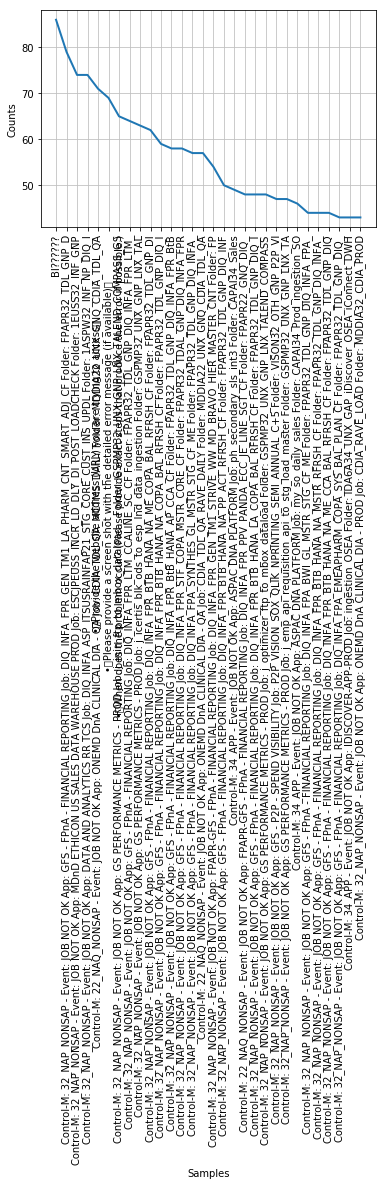

In [30]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [31]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(51872, 60583)
  (0, 53103)	0.5704902407449495
  (0, 21454)	0.30217537438432907
  (0, 45662)	0.23538068752664285
  (0, 59527)	0.11856055548657887
  (0, 45024)	0.24679874772870777
  (0, 59675)	0.15871898086362987
  (0, 34878)	0.6539640037385936
  (1, 59675)	0.17517878701454756
  (1, 31561)	0.23501150030659892
  (1, 26816)	0.1614345867256912
  (1, 5231)	0.31219638976129466
  (1, 26821)	0.17441824293839994
  (1, 4016)	0.48208472574213507
  (1, 30454)	0.2623145587378124
  (1, 54224)	0.19425651120437262
  (1, 30830)	0.1609793181849825
  (1, 30793)	0.21043381607507544
  (1, 11113)	0.5924403917412752
  (2, 31561)	0.0796262425748784
  (2, 26816)	0.1093940470642933
  (2, 5231)	0.21155582113813778
  (2, 26821)	0.11819225274999985
  (2, 31540)	0.11098315712076114
  (2, 55433)	0.1235057399079231
  (2, 58518)	0.11518330622758718
  :	:
  (51870, 45411)	0.32165853971306646
  (51870, 22388)	0.2571366404246993
  (51870, 23478)	0.39375183549611553
  (51870, 22540)	0.39547666661223285
  (51870, 40660)	0.

In [33]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

51872
                                         Description  index
0  SIMS  blank page when open with IE\r\n??IE ??S...      0
1  For dim_slt_id=203, dim_task_id=1658 exited wi...      1
2  For DIM_SLT_ID=203, following task(s) violated...      2
3                                             ??????      3
4                            > DS huddle Login issue      4


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 7].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['When', 'did', 'this', 'issue', 'begin?:2018-02-06\n\nWho', 'is', 'this', 'affecting?:Self\n\nWhat', 'is', 'the', 'issue?:•', 'Jiff', '(mobile', 'app)', '\n•', 'Screenshot', 'not', 'available\n•', 'while', 'logging', 'in', 'I', 'receive', 'a', 'message', 'that', 'i', 'am', 'not', 'authorized', 'to', 'access', 'the', 'app\n\nWhat', 'is', 'the', 'business', 'impact?:None\n\nHave', 'you', 'attempted', 'any', 'troubleshooting?:No\n\nWhat', 'troubleshooting', 'steps', 'have', 'you', 'taken?:']


 tokenized and lemmatized document: 
['issu', 'begin', 'affect', 'self', 'issu', 'jiff', 'mobil', 'screenshot', 'avail', 'log', 'receiv', 'messag', 'author', 'access', 'busi', 'impact', 'attempt', 'troubleshoot', 'troubleshoot', 'step', 'take']


0                        [sim, blank, page, open, sim]
1    [dim_slt_id, dim_task_id, exit, statu, fail, f...
2    [dim_slt_id, follow, task, violat, task_end_de...
3                                                   []
4                                 [huddl, login, issu]
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [37]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 blank
1 open
2 page
3 sim
4 dim_slt_id
5 dim_task_id
6 exit
7 fact_run_id
8 fail
9 statu
10 constraint


In [38]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(19, 1), (154, 1)]

In [39]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 19 ("issu") appears 1 time.
Word 154 ("alteryx") appears 1 time.


In [40]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.4246389934468609),
 (1, 0.31261962200590454),
 (2, 0.29883395563322784),
 (3, 0.7953923334694144)]


### Finding out 5 topics using LDA

In [41]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=7, id2word=dictionary, passes=2, workers=2)

In [42]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=7, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.019*"data" + 0.019*"sale" + 0.017*"report" + 0.014*"http" + 0.014*"user"'), (1, '0.059*"fail" + 0.049*"error" + 0.027*"java" + 0.025*"file" + 0.018*"connect"'), (2, '0.036*"issu" + 0.027*"data" + 0.025*"assign" + 0.023*"load" + 0.022*"failur"'), (3, '0.138*"dim_task_id" + 0.130*"task_nam" + 0.113*"start_tim" + 0.113*"end_tim" + 0.074*"task"'), (4, '0.116*"issu" + 0.107*"troubleshoot" + 0.062*"busi" + 0.056*"impact" + 0.056*"affect"'), (5, '0.150*"folder" + 0.138*"control" + 0.137*"event" + 0.071*"prod" + 0.046*"report"'), (6, '0.052*"access" + 0.044*"error" + 0.037*"http" + 0.027*"user" + 0.026*"provid"')]
Topic: 0 
Words: 0.019*"data" + 0.019*"sale" + 0.017*"report" + 0.014*"http" + 0.014*"user" + 0.014*"attach" + 0.012*"product" + 0.011*"page" + 0.010*"need" + 0.010*"issu"
Topic: 1 
Words: 0.059*"fail" + 0.049*"error" + 0.027*"java" + 0.025*"file" + 0.018*"connect" + 0.017*"tabl" + 0.016*"process" + 0.015*"sgnl" + 0.012*"messag" + 0.012*"server"
Topic: 2 
Words: 0.036*"issu" 

In [43]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [44]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [49]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(7)}

In [50]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(134, 7)
(7, 134)


In [51]:
df_lda

,access,account,address,affect,amet,analyt,apach,applic,aspac,aspw,...,time,tri,troubleshoot,type,unabl,updat,user,violat,websit,yxmd
0,0.007740,0.006459,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.006075,0.014007,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.009505,0.000000,0.000000,0.000000,...,0.008323,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009522,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.008219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064671,0.000000,0.002697
4,0.002765,0.000000,0.000000,0.055635,0.002823,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.107161,0.000000,0.000000,0.000000,0.017868,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.01675,0.000000,0.000000,0.019654,0.008128,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.051880,0.000000,0.010153,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.01744,0.000000,0.000000,0.025097,0.000000,0.026707,0.000000,0.019237,0.000000


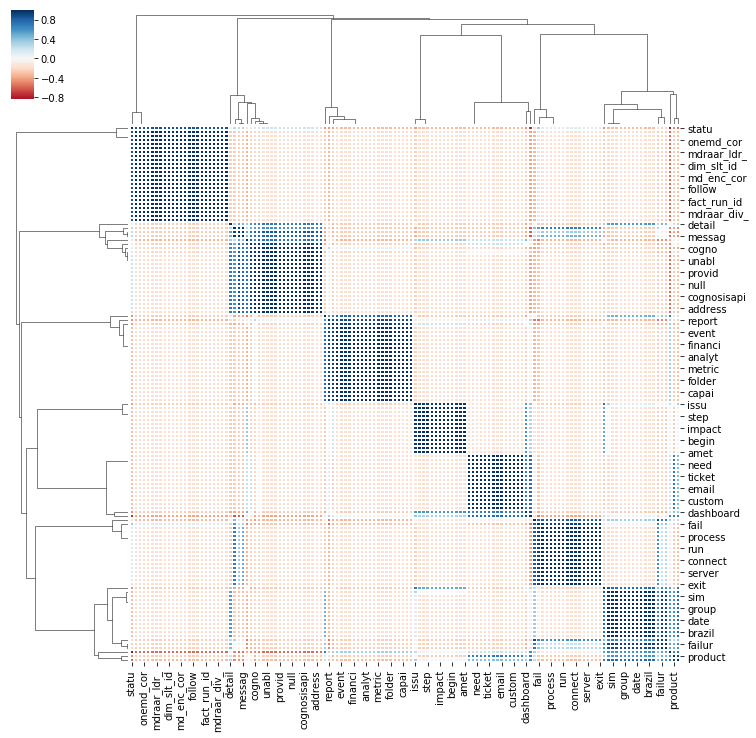

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [48]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [49]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3,random_state=42)
    return X_train, X_test, y_train, y_test

In [50]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [51]:
from sklearn.externals import joblib

In [52]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Create Model for Sub_Category
This model will help to preduct the Sub-Category of the ticket.  Category to Sub Category is one to many relationship; so there is no need to preduct Category as using regular code, we can determine the Category

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          7654784   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                396       
Total params: 9,703,212
Trainable params: 9,703,212
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 272

['model-simple_sub.pkl']

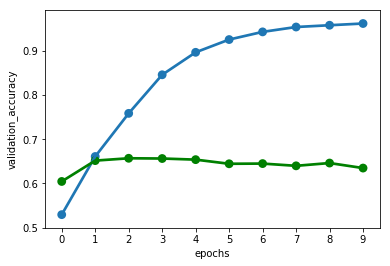

In [53]:

X_train, X_test, y_train, y_test = data_set_split(y_sub)

model_file = 'weights-simple_sub.hdf5'
model = model_training(num_class_sub, model_file)
joblib.dump(model,'model-simple_sub.pkl')


In [54]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6395064901683588

In [59]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [61]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
encoder.fit(data.Sub_Category.values)
#encoder.fit(data.Resolution_category.values)
#encoder.fit(data.Resolved_by_group.values)
text_labels = encoder.classes_ 


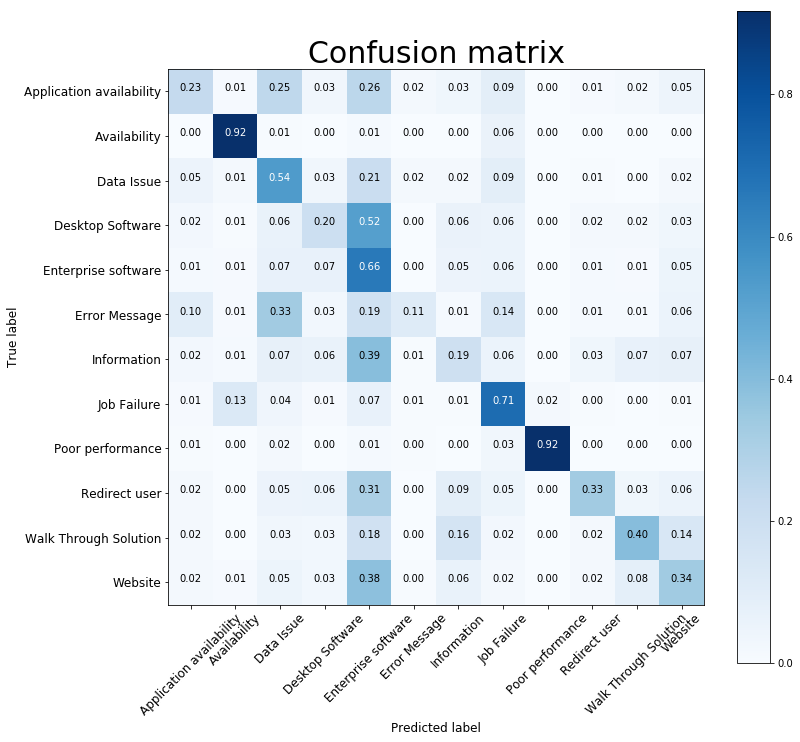

In [62]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [89]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          3156480   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 3,208,199
Trainable params: 3,208,199
Non-trainable params: 0
_________________________________________________________________
Train on 10986 samples, validate on 3663 samples
Epoch 1/20
10986/10986 [==============================] - 64s 6ms/step - loss: 1.24

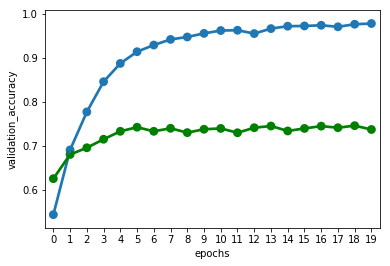

In [90]:
model_lstm = lstm_model_training(num_class_sub,"weights_sub.hdf5")
predicted = model_lstm.predict(X_test)

In [91]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.7344559585492227

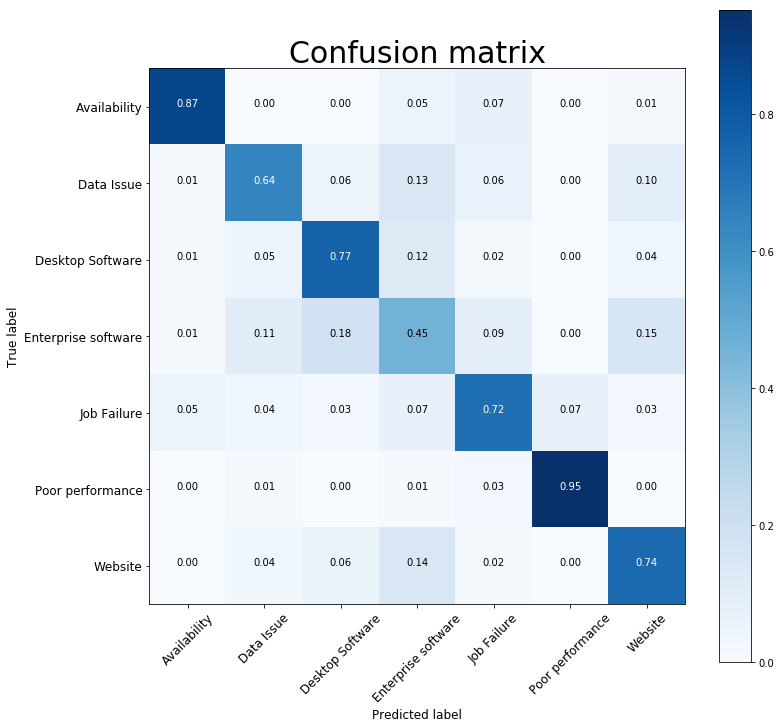

In [92]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        99
           1       0.76      0.64      0.70       126
           2       0.74      0.77      0.75       129
           3       0.42      0.45      0.44        99
           4       0.70      0.72      0.71       103
           5       0.93      0.95      0.94       105
           6       0.69      0.74      0.72       111

   micro avg       0.73      0.73      0.73       772
   macro avg       0.74      0.73      0.74       772
weighted avg       0.74      0.73      0.74       772

